In [2]:
from models import *
from dataset.chaotic_system import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import *
import copy
import os
import time


class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


names = [
    'rossler',
    'rabinovich_fabrikant',
    'lorentz',
    'chua',
]
names = [n + '1d' for n in names]

n_dim = 1
horizon = 10
N = 10000

N_h = 200
num_prepare = 0
num_train = 2000
num_test = 2000
train_start = 0
test_start = 5000
np.random.seed()
nz = 100
connectivity = 1
reservoirConf = Dict(
    alpha=0.9,
    connectivity=1,
    nz=nz,
    nu=n_dim,
    target_rho=0.99,
    input_scale=1,
    #     activation = lambda x: 1/(1 + np.exp(-x))  # sigmoid
    #     activation = lambda x: np.maximum(0,x)
    #     activation = lambda x: x/(1 + np.exp(-x))
    activation=np.tanh
    #     activation = lambda x: np.sin(x)
)
path = 'result/recursive_multistep_prediction'
if not os.path.exists(path):
    os.makedirs(path)


def select_model(model_confs):
    MSE = [0.0] * len(model_confs)
    for j, conf in enumerate(model_confs):
        _, model_type, kwargs = conf
        model = model_type(**kwargs)
        model.train(x_train, y_train, num_prepare=num_prepare)
        Predictions = model.predict(x_test, num_prepare=num_prepare)
        MSE[j] = mse(Predictions, y_test)
    best_model = model_confs[np.argmin(MSE)]
    return best_model
    
    
for file in range(1):
    result_file = path + '/result_'+str(file) + '.csv'
    if os.path.exists(result_file):
        result = pd.read_csv(result_file)
    else:
        result = pd.DataFrame(columns=['datetime', 'system_name',  'n_dim', 'n_history', 'horizon', 'model_name', 'N_h', 'sigma','skip_con','encoder_type','nz', 'connectivity', 'mse'])

    process_start_time = time.time()
    print('开始数据处理')
    for system_name in names:
        print(system_name)
        for n_history in [20]:
        
            '''
            数据集
            '''
            x = np.loadtxt('dataset/'+system_name+'.txt', delimiter=',').T
            x += np.random.randn(*x.shape)*0.001

            x_train = np.vstack([select_samples(x, train_start + i, num_train+num_prepare) for i in range(n_history)])
            y_train = select_samples(x, train_start+ num_prepare + n_history, num_train)
            x_test  = np.vstack([select_samples(x, test_start + i, num_test+num_prepare) for i in range(n_history)])
            y_test  = select_samples(x, test_start + num_prepare + n_history, num_test) 
            y_test_multi  = np.vstack([select_samples(x, test_start + num_prepare + n_history + i, num_test) 
                                for i in range(horizon)])

            rc = reservoirConf


            '''
            单步预测
            '''
            model_confs = []
            model_confs.append(
                [('ESN-transform', 
                ESN, 
                dict(reservoirConf=rc,encoder='transform',skip_con=n_dim))]
            )

            model_confs.append(
                [('ESN-ATTN-simple-transform', 
                ESN_ATTN_simple, 
                dict(N_h=N_h, sigma=sigma, reservoirConf=rc, encoder='transform',skip_con=n_dim)) 
                for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
            )
            
#             model_confs.append(
#                 [('ESN-ATTN-transform',
#                 ESN_ATTN, 
#                 dict(N_h=N_h, sigma=sigma, reservoirConf=rc,encoder='transform',skip_con=n_dim))
#                 for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#             )
            


            colors = list(cnames.keys())


            for j, confs in enumerate(model_confs):
            
                conf = select_model(confs)
                
                model_name, model_class, kwargs = conf
                print(model_name)

                model = model_class(**kwargs)
                model.train(x_train, y_train, num_prepare=num_prepare)
                pred = model.predict_multistep(x_test, horizon)
                print(model.W_o.shape)
                
#                 plt.figure(figsize=(25,horizon+1))
#                 plt.subplot(horizon+1, 1, 1)
#                 plt.plot(x_test[-1])
#                 for i in range(horizon):
#                     plt.subplot(horizon+1,1,i+2)
#                     error = np.sum(np.square(pred[i*n_dim:(i+1)*n_dim,:] - y_test_multi[i*n_dim:(i+1)*n_dim,:]), axis=0)
# #                     print(len(error[error<1])/len(error))
#                     plt.plot(error)
#                 plt.show()
                error = np.sum(np.square(pred[-n_dim:,:] - y_test_multi[-n_dim:,:]), axis=0)
                print('{}% data within range'.format(len(error[error<1])/len(error)*100))
                if len(error[error<1])/len(error) < 0.9:
                    print('bad case for analysis, drop it')
                    continue
                mask = error<1
                MSE = [np.average(np.sum(np.square(pred[i*n_dim:(i+1)*n_dim,mask] - y_test_multi[i*n_dim:(i+1)*n_dim,mask]), axis=0)) for i in range(horizon)]
                print('MSE',MSE)

                for k in range(len(MSE)):
                    result.loc[result.shape[0]] = {
                        'datetime'          : pd.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                        'system_name'       : system_name,
                        'n_dim'             : n_dim,
                        'n_history'         : n_history,
                        'horizon'           : k+1,
                        'model_name'        : model_name,
                        'N_h'               : N_h,
                        'sigma'             : kwargs.get('sigma', 0),
                        'skip_con'          : kwargs.get('skip_con'),
                        'nz'                : nz,
                        'connectivity'      : connectivity,
                        'encoder_type'      : kwargs.get('encoder'),
                        'mse'               : MSE[k]
                    }
#                     print(result.loc[result.shape[0]-1])



    result.to_csv(result_file, index=False)

    print('结束数据处理')
    process_stop_time = time.time()

    # 差的时间戳
    diff_time = process_stop_time - process_start_time
    # 将计算出来的时间戳转换为结构化时间
    struct_time = time.gmtime(diff_time)
    # 减去时间戳最开始的时间 并格式化输出
    print('数据处理用了{0}年{1}月{2}日{3}小时{4}分钟{5}秒'.format(
        struct_time.tm_year - 1970,
        struct_time.tm_mon - 1,
        struct_time.tm_mday - 1,
        struct_time.tm_hour,
        struct_time.tm_min,
        struct_time.tm_sec
    ))

开始数据处理
rossler1d
ESN-transform
(1, 102)
100.0% data within range
MSE [4.205718915492869e-06, 1.1977628650581963e-05, 2.819923380831614e-05, 5.534777271898897e-05, 9.291766747832527e-05, 0.00014243993606545657, 0.00020499070298180387, 0.00027892261170712264, 0.00036486493609272705, 0.0004626678221232606]
ESN-ATTN-simple-transform
(1, 302)
100.0% data within range
MSE [2.6780817786108306e-06, 5.219953811345159e-06, 9.491810773184832e-06, 1.5301809860857068e-05, 2.149629950574338e-05, 2.844227224610597e-05, 3.658835960375409e-05, 4.650611521357906e-05, 5.880794446173412e-05, 7.34615672157505e-05]
rabinovich_fabrikant1d
ESN-transform
(1, 102)
100.0% data within range
MSE [5.257999366458145e-06, 1.7053778692541543e-05, 4.373091069565037e-05, 9.103179720069318e-05, 0.0001647270322519593, 0.000264121327513935, 0.0003931656096641317, 0.0005568528756125021, 0.000762726971469761, 0.0010090727524757828]
ESN-ATTN-simple-transform
(1, 302)
100.0% data within range
MSE [3.13216777596664e-06, 6.69864

In [3]:
1+1

2

# result analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime



system_names = [
    'lorentz',
    'rossler',
    'rabinovich_fabrikant',
    'chua'
]
system_names = [system + '1d' for system in system_names]

path = 'result/recursive_multistep_prediction'
# path = 'result/direct_multistep_prediction'
result_file0 = path + '/result_0.csv' 
print(result_file0)
df = pd.read_csv(result_file0, index_col = 'datetime')
df.index = pd.DatetimeIndex(df.index)
print(set(df['model_name']))
df

result/recursive_multistep_prediction/result_0.csv
{'ESN-transform', 'ESN-ATTN-simple-transform', 'ESN-ATTN-transform'}


,system_name,n_dim,n_history,horizon,model_name,N_h,sigma,skip_con,encoder_type,nz,connectivity,mse
datetime,,,,,,,,,,,,
2020-08-17 12:10:27,rossler1d,1,20,1,ESN-transform,200,0.0,1,transform,100,1,0.000004
2020-08-17 12:10:27,rossler1d,1,20,2,ESN-transform,200,0.0,1,transform,100,1,0.000013
2020-08-17 12:10:27,rossler1d,1,20,3,ESN-transform,200,0.0,1,transform,100,1,0.000031
2020-08-17 12:10:27,rossler1d,1,20,4,ESN-transform,200,0.0,1,transform,100,1,0.000062
2020-08-17 12:10:27,rossler1d,1,20,5,ESN-transform,200,0.0,1,transform,100,1,0.000109
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-10 20:54:19,chua1d,1,20,6,ESN-ATTN-simple-transform,200,0.5,1,transform,100,1,0.000352
2020-11-10 20:54:19,chua1d,1,20,7,ESN-ATTN-simple-transform,200,0.5,1,transform,100,1,0.000572
2020-11-10 20:54:19,chua1d,1,20,8,ESN-ATTN-simple-transform,200,0.5,1,transform,100,1,0.000855


lorentz1d
                    model_name       mse  horizon
0    ESN-ATTN-simple-transform  0.000003        1
1                ESN-transform  0.000005        1
2    ESN-ATTN-simple-transform  0.000005        2
3                ESN-transform  0.000012        2
4    ESN-ATTN-simple-transform  0.000008        3
..                         ...       ...      ...
175              ESN-transform  0.000225        8
176  ESN-ATTN-simple-transform  0.000075        9
177              ESN-transform  0.000343        9
178  ESN-ATTN-simple-transform  0.000104       10
179              ESN-transform  0.000490       10

[180 rows x 3 columns]


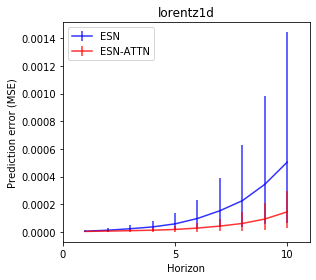

rossler1d
                    model_name       mse  horizon
0    ESN-ATTN-simple-transform  0.000003        1
1                ESN-transform  0.000005        1
2    ESN-ATTN-simple-transform  0.000007        2
3                ESN-transform  0.000013        2
4    ESN-ATTN-simple-transform  0.000013        3
..                         ...       ...      ...
175              ESN-transform  0.000343        8
176  ESN-ATTN-simple-transform  0.000089        9
177              ESN-transform  0.000460        9
178  ESN-ATTN-simple-transform  0.000113       10
179              ESN-transform  0.000597       10

[180 rows x 3 columns]


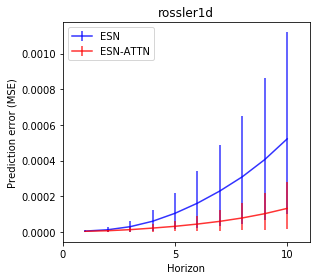

rabinovich_fabrikant1d
                    model_name       mse  horizon
0    ESN-ATTN-simple-transform  0.000003        1
1                ESN-transform  0.000006        1
2    ESN-ATTN-simple-transform  0.000008        2
3                ESN-transform  0.000019        2
4    ESN-ATTN-simple-transform  0.000016        3
..                         ...       ...      ...
175              ESN-transform  0.000609        8
176  ESN-ATTN-simple-transform  0.000144        9
177              ESN-transform  0.000854        9
178  ESN-ATTN-simple-transform  0.000182       10
179              ESN-transform  0.001154       10

[180 rows x 3 columns]


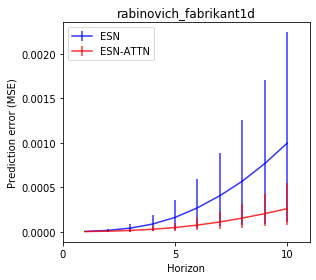

chua1d
                    model_name       mse  horizon
0    ESN-ATTN-simple-transform  0.000005        1
1                ESN-transform  0.000027        1
2    ESN-ATTN-simple-transform  0.000015        2
3                ESN-transform  0.000187        2
4    ESN-ATTN-simple-transform  0.000041        3
..                         ...       ...      ...
175              ESN-transform  0.007243        8
176  ESN-ATTN-simple-transform  0.001323        9
177              ESN-transform  0.009348        9
178  ESN-ATTN-simple-transform  0.001948       10
179              ESN-transform  0.011709       10

[180 rows x 3 columns]


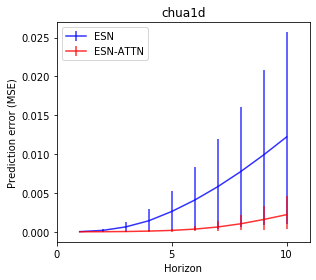

In [5]:
model_names = ['ESN-transform',  
#                'ESN-ATTN-transform',
               'ESN-ATTN-simple-transform']
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

for system_name in system_names:
    print(system_name)

    average = pd.DataFrame()
    for i in range(11,20):
        result_file = path + '/result_' +str(i) + '.csv' 
        df = pd.read_csv(result_file, index_col = 'datetime')
        df.index = pd.DatetimeIndex(df.index)

        result = df[df['system_name'].isin([system_name]) & 
                    df['model_name'].isin(model_names) & 
                    df['horizon'].isin(list(range(11))) 
#                     df['skip_con'].isin([20])
                   ]
#         print(result)

        final = None
        for w in set(result['horizon']):

            temp = result.loc[result['horizon'] == w, ['model_name', 'mse', 'horizon']].groupby('model_name').min().reset_index()

            final = temp if final is None else final.append(temp, ignore_index=True)

        average = average.append(final,ignore_index=True)

    print(average)
    fig, ax = plt.subplots(figsize=(4.5,4))
    for name, c in zip(model_names,['blue','red']):
        qlow = average.loc[average['model_name'] == name].groupby('horizon').agg(q25).sort_values(by='horizon')
        qhigh = average.loc[average['model_name'] == name].groupby('horizon').agg(q75).sort_values(by='horizon')
        yerr = np.array([[qlow.iloc[i] for i in range(10)], [qhigh.iloc[i] for i in range(10)]]).reshape((1,2,10))
        average.loc[average['model_name'] == name].groupby('horizon').median().sort_values(by='horizon')\
                .plot(ax = ax, yerr=yerr, color=c, alpha=0.8)

    plt.legend(labels= ['ESN',  
                        'ESN-ATTN',
#                         'ESN-ATTN-simple',
                       ],
               loc='upper left')
#     ax.set_yscale("log")
#     ax.set_xscale("log")
    plt.xlabel('Horizon')
    plt.ylabel('Prediction error (MSE)')
    plt.xticks([0,5,10])
    plt.xlim([0,11])
    plt.title(system_name)
    plt.tight_layout()

    plt.savefig(path+'/'+system_name+'_horizon.pdf')
    plt.show()

In [4]:
from models import *
from dataset.chaotic_system import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import *
import copy
import os
import time
import random

class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


names = [
    'Rossler',
    'Rabinovich Fabrikant',
    'Lorenz',
]

n_dim = 1
horizon = 100
N = 20000

N_h = 100
num_prepare = 0
num_train = 10000
num_test = 2000
train_start = 0
test_start = 15000

nz = 100
connectivity = 1
reservoirConf = Dict(
    alpha=0.9,
    connectivity=1,
    nz=nz,
    nu=n_dim,
    target_rho=0.99,
    input_scale=1,
    #     activation = lambda x: 1/(1 + np.exp(-x))  # sigmoid
    #     activation = lambda x: np.maximum(0,x)
    #     activation = lambda x: x/(1 + np.exp(-x))
    activation=np.tanh
    #     activation = lambda x: np.sin(x)
)
path = 'result/recursive_multistep_prediction'
if not os.path.exists(path):
    os.makedirs(path)


def select_model(model_confs):
    MSE = [0.0] * len(model_confs)
    for j, conf in enumerate(model_confs):
        _, model_type, kwargs = conf
        model = model_type(**kwargs)
        model.train(x_train, y_train, num_prepare=num_prepare)
        Predictions = model.predict(x_test, num_prepare=num_prepare)
        MSE[j] = mse(Predictions, y_test)
    best_model = model_confs[np.argmin(MSE)]
    return best_model
    
    
for seed in range(1):
    np.random.seed(seed)
    random.seed(seed)
    result_file = path + '/result_seed_'+str(seed) + '.csv'
    if os.path.exists(result_file):
        result = pd.read_csv(result_file)
    else:
        result = pd.DataFrame(columns=['datetime', 'system_name',  'n_dim', 'n_history', 'horizon', 'model_name', 'N_h', 'sigma','skip_con','encoder_type','nz', 'connectivity', 'mse'])

    process_start_time = time.time()
    print('开始数据处理')
    for system_name in names:
        print(system_name)
        for n_history in [20]:
        
            '''
            数据集
            '''
            x = np.loadtxt('dataset/'+system_name+'.csv', delimiter=',').T[0:1]
            x += np.random.randn(*x.shape)*0.001

            x_train = np.vstack([select_samples(x, train_start + i, num_train+num_prepare) for i in range(n_history)])
            y_train = select_samples(x, train_start+ num_prepare + n_history, num_train)
            x_test  = np.vstack([select_samples(x, test_start + i, num_test+num_prepare) for i in range(n_history)])
            y_test  = select_samples(x, test_start + num_prepare + n_history, num_test) 
            y_test_multi  = np.vstack([select_samples(x, test_start + num_prepare + n_history + i, num_test) 
                                for i in range(horizon)])

            rc = reservoirConf


            '''
            单步预测
            '''
            model_confs = []
            model_confs.append(
                [('ESN-transform', 
                ESN, 
                dict(reservoirConf=rc,encoder='transform',skip_con=n_dim))]
            )

            model_confs.append(
                [('ESN-ATTN-simple-transform', 
                ESN_ATTN_simple, 
                dict(N_h=N_h, sigma=sigma, reservoirConf=rc, encoder='transform',skip_con=n_dim)) 
                for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
            )
            
#             model_confs.append(
#                 [('ESN-ATTN-transform',
#                 ESN_ATTN, 
#                 dict(N_h=N_h, sigma=sigma, reservoirConf=rc,encoder='transform',skip_con=n_dim))
#                 for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#             )
            


            colors = list(cnames.keys())


            for j, confs in enumerate(model_confs):
            
                conf = select_model(confs)
                
                model_name, model_class, kwargs = conf
                print(model_name)

                model = model_class(**kwargs)
                model.train(x_train, y_train, num_prepare=num_prepare)
                pred = model.predict_multistep(x_test, horizon)
                print(model.W_o.shape)
                
                error = np.sum(np.square(pred[-n_dim:,:] - y_test_multi[-n_dim:,:]), axis=0)

 
                MSE = [np.average(np.sum(np.square(pred[i*n_dim:(i+1)*n_dim] - y_test_multi[i*n_dim:(i+1)*n_dim]), axis=0)) for i in range(horizon)]
                print('MSE',MSE)

                for k in range(len(MSE)):
                    result.loc[result.shape[0]] = {
                        'datetime'          : pd.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                        'system_name'       : system_name,
                        'n_dim'             : n_dim,
                        'n_history'         : n_history,
                        'horizon'           : k+1,
                        'model_name'        : model_name,
                        'N_h'               : N_h,
                        'sigma'             : kwargs.get('sigma', 0),
                        'skip_con'          : kwargs.get('skip_con'),
                        'nz'                : nz,
                        'connectivity'      : connectivity,
                        'encoder_type'      : kwargs.get('encoder'),
                        'mse'               : MSE[k]
                    }
#                     print(result.loc[result.shape[0]-1])



    result.to_csv(result_file, index=False)

    print('结束数据处理')
    process_stop_time = time.time()

    # 差的时间戳
    diff_time = process_stop_time - process_start_time
    # 将计算出来的时间戳转换为结构化时间
    struct_time = time.gmtime(diff_time)
    # 减去时间戳最开始的时间 并格式化输出
    print('数据处理用了{0}年{1}月{2}日{3}小时{4}分钟{5}秒'.format(
        struct_time.tm_year - 1970,
        struct_time.tm_mon - 1,
        struct_time.tm_mday - 1,
        struct_time.tm_hour,
        struct_time.tm_min,
        struct_time.tm_sec
    ))

开始数据处理
Rossler
ESN-transform
(1, 102)
MSE [4.78107500609028e-06, 1.4952082576515806e-05, 3.983544137921973e-05, 9.177470176907062e-05, 0.00020383925258958557, 0.0004538480431567968, 0.001024531850160208, 0.002473610332465008, 0.007352418319491662, 0.04527764529533901, 2.6681221633584538, 529.9568965482113, 120771.32942923538, 27808405.660124, 6407743579.59848, 1476576604544.3623, 340257994967540.25, 7.840807587509416e+16, 1.8068132277152643e+19, 4.163568620952495e+21, 9.59440820819778e+23, 2.21090793130576e+26, 5.094752875467406e+28, 1.174020251795565e+31, 2.705378622510071e+33, 6.2341969654617e+35, 1.4365904824113834e+38, 3.3104379370569466e+40, 7.628478309775983e+42, 1.7578846795858713e+45, 4.0508190771974136e+47, 9.334591390859733e+49, 2.15103648851672e+52, 4.956786838533691e+54, 1.1422277536353306e+57, 2.632116900876784e+59, 6.06537475370526e+61, 1.3976875757543462e+64, 3.220791193857683e+66, 7.421898923894001e+68, 1.7102811179299616e+71, 3.9411227939669736e+73, 9.081810419520816e+

Lorenz
ESN-transform
(1, 102)
MSE [1.9540870578868126e-06, 2.8240275937424252e-06, 4.3941401078762944e-06, 6.769011246554265e-06, 1.0371100132584644e-05, 1.552267953316419e-05, 2.27835009063688e-05, 3.283582869835644e-05, 4.552959839880655e-05, 6.207873573208787e-05, 8.2787131438081e-05, 0.00010744831144327252, 0.0001367120235754957, 0.00017099464814401393, 0.00021092957526303762, 0.00025673631629101565, 0.00030996922808780944, 0.00037174227857250306, 0.0004423832117479389, 0.0005253228331710622, 0.0006224535754485488, 0.0007366714689337292, 0.0008716699345737883, 0.0010312566379766074, 0.0012223441121761627, 0.0014510570991329175, 0.0017254469777349191, 0.0020535991066870556, 0.002446481634777681, 0.002916914808857487, 0.0034766284809482, 0.004141899034642097, 0.00492782628094829, 0.005854286823640848, 0.006938621403080982, 0.008202202430571912, 0.009666677862915115, 0.011355679611447754, 0.013295285040619501, 0.015513995165913105, 0.01804110024778425, 0.020918495604301455, 0.02418323